In [3]:

import json
config = {
    "savepath":"C:\\Users\\alber\\Desktop\\Files\\Università\\V ANNO ACCADEMICO\\Capstone Project\\Qura-ECC-Pump-Tester\\tests",
    "append": "today",
    "colors":    {
        "S1": "#219ebc",
        "S2": "#f77f00",
        "S3": "#38b000",
        "S4": "#fee440",
        "S5": "#8338ec",
        "S6": "#e71d36",
    }
}

with open('config\\config.json', 'w') as outfile:
    json.dump(config, outfile,indent=4)
    
with open('config\\config.json') as outfile:
    config_read=json.load(outfile)
config_read

{'savepath': 'C:\\Users\\alber\\Desktop\\Files\\Università\\V ANNO ACCADEMICO\\Capstone Project\\Qura-ECC-Pump-Tester\\tests',
 'append': 'today',
 'colors': {'S1': '#219ebc',
  'S2': '#f77f00',
  'S3': '#38b000',
  'S4': '#fee440',
  'S5': '#8338ec',
  'S6': '#e71d36'}}

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import sklearn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from rich import print

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print("Using TensorFlow version", tf.__version__)

seed = 69
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("RNG seed: ",seed)

Using TensorFlow version 2.6.0

RNG seed:  69

In [43]:
dataset_dir = "C:\\Users\\alber\\Desktop\\Files\\Università\\V ANNO ACCADEMICO\\Capstone Project\\Qura-ECC-Pump-Tester\\data"
# colnames = ['s1','s2','s3','s4','s5','s6']
data = pd.read_csv(os.path.join(dataset_dir,"compliant","14122021_171124_5433_500_c.csv"))#,names=colnames)
data.head()

,1612,1122,2298,889,990,1609,Unnamed: 6
0,1578,1111,2298,884,984,1567,NaN
1,1537,1121,2299,874,986,1517,NaN
2,1504,1094,2300,862,1014,1509,NaN
3,1472,1071,2302,849,1044,1516,NaN
4,1472,1053,2299,840,1072,1550,NaN


In [44]:
data = pd.read_csv('C:\\Users\\alber\\Desktop\\Files\\Università\\V ANNO ACCADEMICO\\Capstone Project\\Qura-ECC-Pump-Tester\\data2\\noncompliant\\3138nc.csv')#,names=colnames)
plt.figure(figsize=(10,5))
plt.plot(data)
plt.legend(['S1','S2','S3','S4','S5','S6'])
plt.title("Example of a recording");
plt.grid(True)

In [45]:
data = pd.read_csv('C:\\Users\\alber\\Desktop\\Files\\Università\\V ANNO ACCADEMICO\\Capstone Project\\Qura-ECC-Pump-Tester\\data3\\14122021_155621_5284_500_c.csv')#,names=colnames)
plt.figure(figsize=(10,5))
plt.plot(data)
plt.legend(['S1','S2','S3','S4','S5','S6'])
plt.title("Example of a recording");
plt.grid(True)

### Loading dataset in memory

In [115]:
xtrainc = []
correct = 0;
noncorrect = 0;
for file in os.listdir(os.path.join(dataset_dir,"compliant")):
    # print(file)
    try:
        data = np.genfromtxt(os.path.join(dataset_dir,"compliant",file), delimiter=',')
        # print(data)
        correct+=1;
        # if np.amax(data)>maxval: maxval=np.amax(data)
        xtrainc.append(data)
    except:
        print(f"[red]Error occured while loading",os.path.join(dataset_dir,"noncompliant",file),"\n Skipping")
        noncorrect+=1;
        pass
ytrainc=np.ones((len(xtrainc),))
xtrainnc=[]
for file in os.listdir(os.path.join(dataset_dir,"noncompliant")):
    # print(file)
    try:
        data = np.genfromtxt(os.path.join(dataset_dir,"noncompliant",file), delimiter=',')
        correct+=1;
        # if np.amax(data)>maxval: maxval=np.amax(data)
        xtrainnc.append(data)
    except:
        print(f"[red]Error occured while loading",os.path.join(dataset_dir,"noncompliant",file),"\n Skipping")
        noncorrect+=1;
        pass
ytrainnc=np.zeros((len(xtrainnc),))

print(f"[green]{correct} files loaded corrctly")
print(f"[red]{noncorrect} files loaded incorrectly")

102 files loaded corrctly

0 files loaded incorrectly

Select here which sensors are working, as well as the window size and the stride

In [116]:
WORKING_SENSORS = [1,2,3,4,5,6]
WINDOW_SIZE = 125;
STRIDE = 25;

In [117]:
label = {0: "NON-COMPLIANT",1:"COMPLIANT"}

In [118]:
WORKING_SENSORS = [ws-1 for ws in WORKING_SENSORS]

xtrainw = []
ytrainw = []
for x in xtrainc:
    windows = [x[i:i+WINDOW_SIZE,WORKING_SENSORS] for i in range(0,x.shape[0]-WINDOW_SIZE,STRIDE)]
    xtrainw += windows
    ytrainw += [1 for i in range(len(windows))]
    # print(len(xtrainw))
    # print(len(ytrainw))
for x in xtrainnc:
    windows = [x[i:i+WINDOW_SIZE,WORKING_SENSORS] for i in range(0,x.shape[0]-WINDOW_SIZE,STRIDE)]
    xtrainw += windows
    ytrainw += [0 for i in range(len(windows))]
    # print(len(xtrainw))
    # print(len(ytrainw))
Xw=np.stack(xtrainw,axis=0)
Yw=np.stack(ytrainw,axis=0)
Xw,Yw = sklearn.utils.shuffle(Xw,Yw)
print(f"{correct} signals have been splitted in a total of {Xw.shape[0]} windows")


102 signals have been splitted in a total of 882 windows

In [119]:
Xw.shape

(882, 125, 6)

In [120]:
Xw=(Xw-np.expand_dims(np.mean(Xw,axis=1),axis=1))/np.expand_dims(np.std(Xw,axis=1),axis=1)

In [121]:
Xw

array([[[-0.99713327,  0.30941783,  2.68239749, -0.06756358,
         -0.43998052, -1.1155341 ],
        [-1.10101574,  0.14448295,  0.29686613, -1.56543539,
         -0.22077938, -1.2507438 ],
        [-1.2741532 , -0.07543022,  0.56192517, -0.76869506,
          0.12994243, -1.18313895],
        ...,
        [-1.0490745 , -1.31244179, -0.23325196,  0.25113255,
          1.09442742,  0.19599998],
        [-0.78936831, -1.2574635 , -1.29348812, -0.76869506,
          1.26978833,  0.57458714],
        [-0.42577964, -1.09252862, -1.02842908,  0.63356791,
          1.18210788,  0.84500653]],

       [[-1.00188145,  0.20314956,  1.26297707, -0.9109685 ,
         -0.33614032, -1.34460518],
        [-1.16367726, -0.12628216,  1.03115308, -0.88774373,
         -0.07893382, -1.33503122],
        [-1.27328088, -0.48316653,  0.91524109, -1.09676669,
          0.25686356, -1.2201437 ],
        ...,
        [-0.96012769, -1.0871247 , -0.12796684, -1.29417726,
          1.17852018, -0.03297272],
  

In [122]:
for i in range(Xw.shape[0]):
    for j in range(Xw.shape[1]):
        for k in range(Xw.shape[2]):
            if np.abs(Xw[i,j,k]-np.mean(Xw[i,:,k]))>1.90*np.std(Xw[i,:,k]):
                Xw[i,j,k] = np.mean(Xw[i,:,k])

Examples of windowed  signals

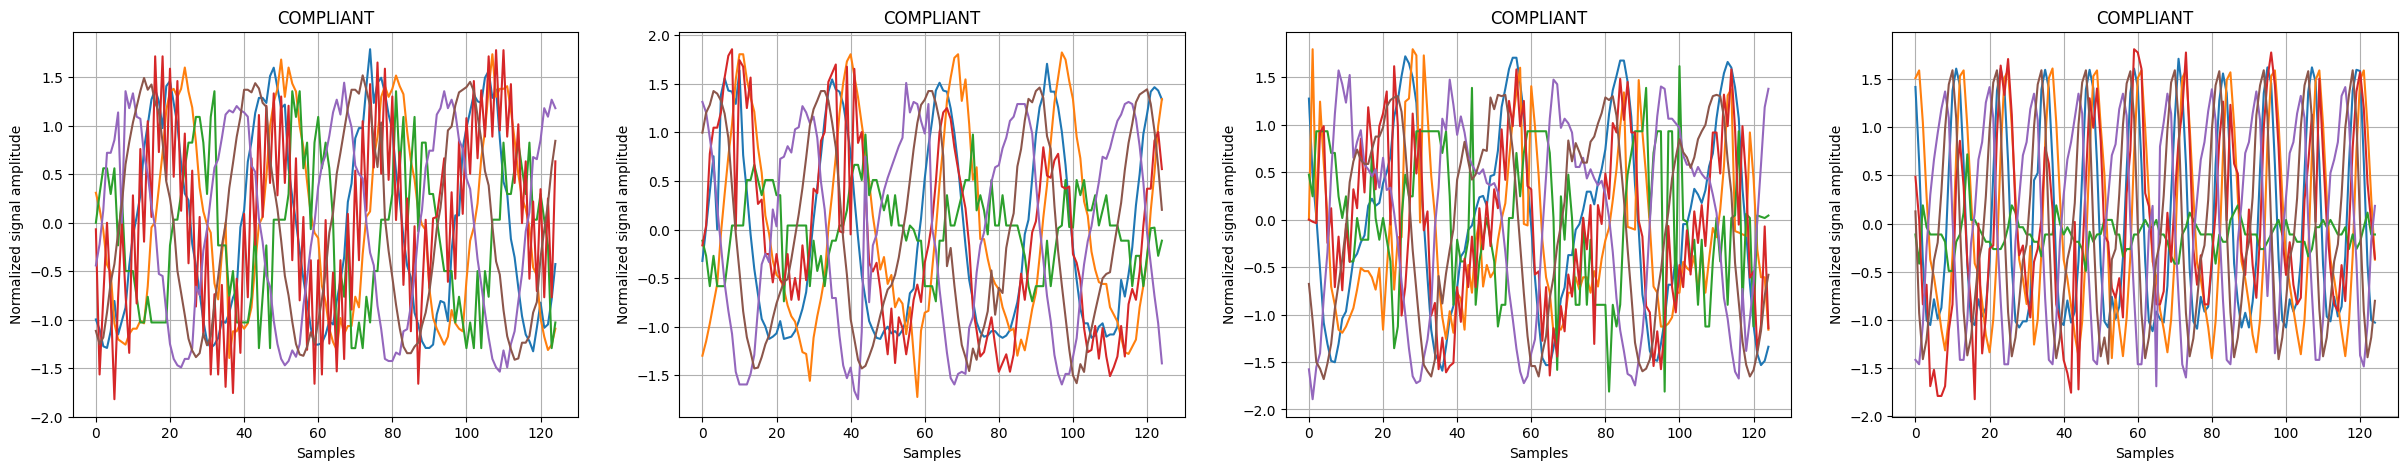

In [123]:
plt.figure(figsize=(30,5))
plt.subplot(1,4,1)
plt.plot(Xw[0])
plt.title(label[Yw[0]])
plt.grid()
plt.xlabel("Samples")
plt.ylabel("Normalized signal amplitude")
plt.subplot(1,4,2)
plt.plot(Xw[100])
plt.title(label[Yw[100]])
plt.grid()
plt.xlabel("Samples")
plt.ylabel("Normalized signal amplitude")
plt.subplot(1,4,3)
plt.plot(Xw[400])
plt.title(label[Yw[400]])
plt.grid()
plt.xlabel("Samples")
plt.ylabel("Normalized signal amplitude")
plt.subplot(1,4,4)
plt.plot(Xw[500])
plt.title(label[Yw[500]])
plt.grid()
plt.xlabel("Samples")
plt.ylabel("Normalized signal amplitude")
plt.show()

Assigning weights to classes to compensate for the dataset inbalance: **less-populated classes have a higher weight**

In [124]:
compliant = np.count_nonzero(Yw==1)
noncompliant = np.count_nonzero(Yw==0)
weights = {
    0:(compliant+noncompliant)/(2*noncompliant), # NON-COMPLIANT
    1:(compliant+noncompliant)/(2*compliant),  # COMPLIANT
}
print(weights)

{0: 0.9149377593360996, 1: 1.1025}

In [125]:
Xw

array([[[-9.97133267e-01,  3.09417829e-01, -2.89510638e-14,
         -6.75635794e-02, -4.39980517e-01, -1.11553410e+00],
        [-1.10101574e+00,  1.44482952e-01,  2.96866125e-01,
         -1.56543539e+00, -2.20779383e-01, -1.25074380e+00],
        [-1.27415320e+00, -7.54302170e-02,  5.61925166e-01,
         -7.68695064e-01,  1.29942433e-01, -1.18313895e+00],
        ...,
        [-1.04907450e+00, -1.31244179e+00, -2.33251956e-01,
          2.51132550e-01,  1.09442742e+00,  1.95999980e-01],
        [-7.89368313e-01, -1.25746350e+00, -1.29348812e+00,
         -7.68695064e-01,  1.26978833e+00,  5.74587137e-01],
        [-4.25779645e-01, -1.09252862e+00, -1.02842908e+00,
          6.33567905e-01,  1.18210788e+00,  8.45006535e-01]],

       [[-1.00188145e+00,  2.03149565e-01,  1.26297707e+00,
         -9.10968502e-01, -3.36140316e-01, -1.34460518e+00],
        [-1.16367726e+00, -1.26282162e-01,  1.03115308e+00,
         -8.87743728e-01, -7.89338168e-02, -1.33503122e+00],
        [-1.27328

In [126]:
folds = 4
skf = StratifiedKFold(n_splits=folds,shuffle=True)
idxs = []
accs = []
tfkl = tf.keras.layers

for fold,(tri,tsi) in enumerate(skf.split(Xw,Yw)):
    idxs.append((tri,tsi))
    print()
    print("Starting training on fold num: {}".format(fold+1))
    xt=Xw[tri]
    yt=Yw[tri]
    # p = sns.histplot(yt)
    xvaltest=Xw[tsi]
    yvaltest=Yw[tsi]
    # xval=Xw[tsi]
    # yval=Yw[tsi]
    xval,xtest,yval,ytest = train_test_split(xvaltest,yvaltest,test_size=0.5,shuffle=69)

# CHANGE THE MODEL HRE
##############################################################################################
    def LSTMclassifier(input_shape, classes):
    # Build the neural network layer by layer
        input_layer = tfkl.Input(shape=input_shape, name='Input')
        x = input_layer
        # Feature extractor
        # x = tfkl.Flatten()(x)
        x = tfkl.Conv1D(kernel_size=10,filters=32,padding='same')(x)
        x = tfkl.Activation('relu')(x)
        
        x = tfkl.LSTM(32, return_sequences=True,activation='relu')(x)
        x = tfkl.Dropout(.2, seed=seed)(x)
        # x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True))(x)
        x = tfkl.LSTM(16, return_sequences=True,activation='relu')(x)
        x = tfkl.Conv1D(kernel_size=4,filters=8,padding='same')(x)
        # x = tfkl.Bidirectional(tfkl.LSTM(16, return_sequences=False))(x)
        x = tfkl.Dropout(.2, seed=seed)(x)
        x = tfkl.Flatten()(x)
        # x = tfkl.LSTM(12)(x)
        # x = tfkl.Dropout(.2, seed=seed)(x)

        # Classifier
        # x = tfkl.Dense(8, activation='relu')(x)
        x = tfkl.Dense(12, activation='relu')(x)
        x = tfkl.Dropout(.05, seed=seed)(x)
        # x = tfkl.Dense(4, activation='relu')(x)
        
        x = tfkl.Dense(1, activation='sigmoid')(x)
        
        output_layer = x
        # Connect input and output through the Model class
        model = tfk.Model(inputs=input_layer, outputs=output_layer, name='qura_pump_classifier')

        # Return the model
        return model
#############################################################################################
    input_shape = Xw.shape[1:]
    classes=1
    
    model = LSTMclassifier(input_shape, classes)
    print(model.summary())  
    
    # Compile the model
    batch_size=32
    lr = 1e-3
    epochs=250
    
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics='accuracy')
    
    history = model.fit(
        x = Xw,
        y = Yw,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(xval,yval),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.1, min_lr=1e-6,verbose=True),
            # tfk.callbacks.TensorBoard(f"G:\\My Drive\\SPIN TEST Capstone\\Recordings_new\\tblogs{run}")
        ],
        class_weight=weights
    ).history
    
    out = model.predict(xtest)
    print(out.shape)
    preds = []
    for i in out:
        preds.append(1) if i>0.5 else preds.append(0)
    true=ytest
    preds = np.stack(preds)
    print("Outputs: ",np.stack(out,axis=0).T)
    print("Predicted: ",preds)
    print("Real:      ", true)
    print()
    print(sklearn.metrics.classification_report(true,preds))
    accs.append(sklearn.metrics.accuracy_score(true,preds))
    cm = confusion_matrix(true,preds)
    plt.figure()
    hm = sns.heatmap(cm, cmap="Greens", annot=True,fmt='.2f')
    hm.set_xticklabels(['COMP','NON-COMP'])
    hm.set_xlabel("Prediction")
    hm.set_ylabel("Real")
    hm.set_yticklabels(['COMP','NON-COMP'])
    hm.set_title("Confusion matrix")
    model.save('model.h5')

Starting training on fold num: 1

Model: "qura_pump_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 125, 6)]          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 125, 32)           1952      
_________________________________________________________________
activation_11 (Activation)   (None, 125, 32)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 125, 32)           8320      
_________________________________________________________________
dropout_33 (Dropout)         (None, 125, 32)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 125, 16)           3136      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 125, 8)   

None

Epoch 1/250
28/28 [==============================] - 3s 68ms/step - loss: 0.6967 - accuracy: 0.5147 - val_loss: 0.6892 - val_accuracy: 0.5636
Epoch 2/250
28/28 [==============================] - 2s 60ms/step - loss: 0.6810 - accuracy: 0.5918 - val_loss: 0.6142 - val_accuracy: 0.7364
Epoch 3/250
28/28 [==============================] - 2s 58ms/step - loss: 0.6095 - accuracy: 0.6837 - val_loss: 0.5339 - val_accuracy: 0.7545
Epoch 4/250
28/28 [==============================] - 2s 58ms/step - loss: 0.5561 - accuracy: 0.7222 - val_loss: 0.4819 - val_accuracy: 0.7727
Epoch 5/250
28/28 [==============================] - 2s 62ms/step - loss: 0.4967 - accuracy: 0.7676 - val_loss: 0.4256 - val_accuracy: 0.8545
Epoch 6/250
28/28 [==============================] - 2s 59ms/step - loss: 0.4498 - accuracy: 0.7993 - val_loss: 0.4004 - val_accuracy: 0.8273
Epoch 7/250
28/28 [==============================] - 2s 58ms/step - loss: 480837536.0000 - accuracy: 0.6667 - val_loss: 52322304.0000 - val_accuracy

(111, 1)

Outputs:  [[0.20931578 0.8179188  0.9363003  0.21324816 0.5688062  0.96921664
  0.1252222  0.10293522 0.2666166  0.24488574 0.3207013  0.23829526
  0.4158805  0.25667465 0.6310405  0.9331536  0.91561997 0.2372551
  0.13637462 0.5906726  0.28257337 0.9234688  0.09523112 0.95270336
  0.8627242  0.12469509 0.3201099  0.12895077 0.46028003 0.98824525
  0.21593454 0.18489844 0.1026369  0.23452744 0.44185638 0.14229989
  0.13547999 0.21903968 0.715735   0.3703711  0.16053218 0.3279272
  0.154345   0.28453887 0.10036474 0.11408693 0.42510897 0.31459045
  0.24571577 0.76198673 0.26831147 0.7472485  0.8967324  0.8569352
  0.6703966  0.29650044 0.32856542 0.7999644  0.1245608  0.12228522
  0.20319897 0.6643956  0.10995996 0.23387858 0.1205608  0.40246812
  0.16053632 0.1630964  0.19639784 0.14828688 0.8245164  0.32295647
  0.7688676  0.4231099  0.71547645 0.1445579  0.50822926 0.9999958
  0.17968974 0.6985731  0.06996316 0.6021102  0.2727477  0.31172156
  0.1019792  0.4439807  0.25150076 0.31815588 0.11538288 0.8307301
  0.45821345 0.26761925 0.26573735 0.89353526 0.24392465 0.12291357
  0.16213858 0.45668674 0.11282367 0.7609515  0.79803944 0.34516537
  0.3369149  0.1699495  0.21166682 0.3402399  0.26703918 0.12139848
  0.29526258 0.4349724  0.74542326]]

Predicted:  [0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0
 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1]

Real:       [0 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0
 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1]

precision    recall  f1-score   support

           0       0.73      0.98      0.84        59
           1       0.97      0.60      0.74        52

    accuracy                           0.80       111
   macro avg       0.85      0.79      0.79       111
weighted avg       0.84      0.80      0.79       111

Starting training on fold num: 2

Model: "qura_pump_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 125, 6)]          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 125, 32)           1952      
_________________________________________________________________
activation_12 (Activation)   (None, 125, 32)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 125, 32)           8320      
_________________________________________________________________
dropout_36 (Dropout)         (None, 125, 32)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 125, 16)           3136      
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 125, 8)   

None

Epoch 1/250
28/28 [==============================] - 4s 78ms/step - loss: 0.6941 - accuracy: 0.4966 - val_loss: 0.6865 - val_accuracy: 0.5909
Epoch 2/250
28/28 [==============================] - 2s 68ms/step - loss: 0.6430 - accuracy: 0.6485 - val_loss: 0.6658 - val_accuracy: 0.6000
Epoch 3/250
28/28 [==============================] - 2s 76ms/step - loss: 0.5998 - accuracy: 0.6848 - val_loss: 0.5658 - val_accuracy: 0.6909
Epoch 4/250
28/28 [==============================] - 2s 68ms/step - loss: 0.5250 - accuracy: 0.7392 - val_loss: 0.5212 - val_accuracy: 0.7273
Epoch 5/250
28/28 [==============================] - 2s 62ms/step - loss: 0.4670 - accuracy: 0.7846 - val_loss: 0.5030 - val_accuracy: 0.7455
Epoch 6/250
28/28 [==============================] - 2s 69ms/step - loss: 0.4305 - accuracy: 0.8152 - val_loss: 0.4255 - val_accuracy: 0.8000
Epoch 7/250
28/28 [==============================] - 2s 65ms/step - loss: 0.3784 - accuracy: 0.8413 - val_loss: 0.4154 - val_accuracy: 0.8273- loss:

(111, 1)

Outputs:  [[7.13437796e-04 1.11180246e-01 7.91419983e-01 1.58959627e-03
  5.44038057e-01 9.96271968e-01 9.99050975e-01 9.96909738e-01
  2.24739313e-04 1.70463324e-02 4.99487221e-02 4.00125980e-04
  9.90625620e-01 9.99875247e-01 9.24632668e-01 8.75234604e-03
  8.63548160e-01 1.00000000e+00 8.95572424e-01 1.52559643e-09
  1.34403663e-07 1.05971098e-02 2.74605453e-02 6.50981665e-02
  1.00000000e+00 9.98371482e-01 7.57690668e-01 5.75448394e-01
  9.99543428e-01 9.99012232e-01 4.91047470e-13 8.12682152e-01
  3.02311778e-03 9.99845266e-01 9.90993261e-01 3.96415591e-03
  9.99992371e-01 9.99999404e-01 9.58482504e-01 1.57829821e-02
  9.99999762e-01 5.25907278e-02 7.89523125e-04 2.06906199e-02
  9.07361507e-04 1.42153651e-01 9.99999762e-01 9.99999583e-01
  5.86292148e-03 8.13419878e-01 9.98510838e-01 9.99171138e-01
  5.64381480e-03 9.69292879e-01 9.53224301e-03 6.58750534e-04
  1.00000000e+00 1.34143233e-03 9.96124148e-01 2.08048405e-05
  3.31845582e-02 1.29909813e-02 5.96087813e-01 9.99996543e-01
  1.07480258e-01 9.96047139e-01 1.19889677e-02 9.46036816e-01
  9.94385004e-01 3.82113457e-02 9.90566730e-01 6.06841085e-15
  4.68914330e-01 9.92336750e-01 3.62875044e-01 2.23442748e-05
  9.09763575e-03 9.99874651e-01 6.49095356e-01 2.56907940e-03
  9.64456797e-01 1.74349844e-02 1.29137129e-01 3.35204601e-03
  4.34433222e-02 5.64777911e-01 9.99905825e-01 9.82713819e-01
  1.00000000e+00 9.93235230e-01 8.12711223e-05 3.14686440e-05
  1.87296569e-02 1.96403265e-03 3.28510255e-01 3.01231951e-01
  1.00000000e+00 9.99995112e-01 5.19116293e-05 2.35223542e-05
  1.06987596e-01 1.13506253e-08 1.89453363e-04 3.19043100e-02
  9.98748779e-01 5.80519438e-04 2.57391334e-02 1.13813949e-05
  1.49450316e-05 1.95495695e-01 9.99929786e-01]]

Predicted:  [0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1
 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1
 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1]

Real:       [0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1
 1 1 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 1 1
 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1]

precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.96      0.96      0.96        51

    accuracy                           0.96       111
   macro avg       0.96      0.96      0.96       111
weighted avg       0.96      0.96      0.96       111

Starting training on fold num: 3

Model: "qura_pump_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 125, 6)]          0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 125, 32)           1952      
_________________________________________________________________
activation_13 (Activation)   (None, 125, 32)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 125, 32)           8320      
_________________________________________________________________
dropout_39 (Dropout)         (None, 125, 32)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 125, 16)           3136      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 125, 8)   

None

Epoch 1/250
28/28 [==============================] - 3s 68ms/step - loss: 0.6951 - accuracy: 0.4717 - val_loss: 0.6919 - val_accuracy: 0.5909
Epoch 2/250
28/28 [==============================] - 2s 57ms/step - loss: 0.6807 - accuracy: 0.5703 - val_loss: 0.6503 - val_accuracy: 0.6545
Epoch 3/250
28/28 [==============================] - 2s 60ms/step - loss: 0.6188 - accuracy: 0.6939 - val_loss: 0.5960 - val_accuracy: 0.6909
Epoch 4/250
28/28 [==============================] - 2s 58ms/step - loss: 0.5603 - accuracy: 0.7256 - val_loss: 0.5507 - val_accuracy: 0.7091
Epoch 5/250
28/28 [==============================] - 2s 58ms/step - loss: 0.5068 - accuracy: 0.7426 - val_loss: 0.5290 - val_accuracy: 0.6818
Epoch 6/250
28/28 [==============================] - 2s 60ms/step - loss: 6680.7261 - accuracy: 0.7664 - val_loss: 0.5257 - val_accuracy: 0.7636
Epoch 7/250
28/28 [==============================] - 2s 58ms/step - loss: 0.4987 - accuracy: 0.7698 - val_loss: 0.4968 - val_accuracy: 0.6909
Epo

(110, 1)

Outputs:  [[0.37422466 0.58210605 0.33774102 0.66167676 0.29787096 0.46694976
  0.6443659  0.40404707 0.5539556  0.8874514  0.31205767 0.29127496
  0.3510784  0.47003776 0.2666183  0.5952343  0.28895563 0.43266302
  0.46719682 0.5140744  0.27980393 0.34823456 0.24719226 0.24301776
  0.28834105 0.41207018 0.29923707 0.7949647  0.8672061  0.16900301
  0.4525188  0.04879996 0.32123786 0.7948029  0.4986862  0.36913866
  0.39271814 0.5364578  0.4522769  0.3024757  0.90060526 0.32619137
  0.6943544  0.5192837  0.3855238  0.68950224 0.41209906 0.27586308
  0.32672843 0.41778445 0.82720304 0.52996844 0.63416797 0.6352102
  0.2839337  0.34014392 0.31239647 0.50500846 0.35859156 0.99997556
  0.3172267  0.49872518 0.96815956 0.74756444 0.46115014 0.8364086
  0.7741703  0.97759414 0.31448346 0.3772859  0.98718613 0.9241689
  0.6380505  0.1841349  0.888392   0.47862104 0.36995155 0.13273805
  0.33710343 0.9244162  0.3676712  0.4569325  0.6404693  0.9941631
  0.9981537  0.55879295 0.38974634 0.40654272 0.5742728  0.43567654
  0.28049773 0.87064934 0.3373937  0.49563923 0.5120008  0.6082223
  0.26281527 0.6712754  0.4372091  0.75585216 0.34968102 0.3285854
  0.55005074 0.45297202 0.32424092 0.3024139  0.55689764 0.693861
  0.38758874 0.30376053]]

Predicted:  [0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0
 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0
 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0]

Real:       [0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1
 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0]

precision    recall  f1-score   support

           0       0.76      0.83      0.79        60
           1       0.77      0.68      0.72        50

    accuracy                           0.76       110
   macro avg       0.77      0.76      0.76       110
weighted avg       0.76      0.76      0.76       110

Starting training on fold num: 4

Model: "qura_pump_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 125, 6)]          0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 125, 32)           1952      
_________________________________________________________________
activation_14 (Activation)   (None, 125, 32)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 125, 32)           8320      
_________________________________________________________________
dropout_42 (Dropout)         (None, 125, 32)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 125, 16)           3136      
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 125, 8)   

None

Epoch 1/250
28/28 [==============================] - 4s 74ms/step - loss: 0.6957 - accuracy: 0.4932 - val_loss: 0.6918 - val_accuracy: 0.5273
Epoch 2/250
28/28 [==============================] - 2s 67ms/step - loss: 0.6915 - accuracy: 0.5000 - val_loss: 0.6832 - val_accuracy: 0.6364
Epoch 3/250
28/28 [==============================] - 2s 62ms/step - loss: 0.6634 - accuracy: 0.6145 - val_loss: 0.5284 - val_accuracy: 0.8000
Epoch 4/250
28/28 [==============================] - 2s 59ms/step - loss: 0.5780 - accuracy: 0.6995 - val_loss: 0.4769 - val_accuracy: 0.7727
Epoch 5/250
28/28 [==============================] - 2s 65ms/step - loss: 0.5106 - accuracy: 0.7506 - val_loss: 0.4056 - val_accuracy: 0.8364
Epoch 6/250
28/28 [==============================] - 2s 61ms/step - loss: 0.4913 - accuracy: 0.7823 - val_loss: 0.4055 - val_accuracy: 0.8636
Epoch 7/250
28/28 [==============================] - 2s 73ms/step - loss: 0.4563 - accuracy: 0.7834 - val_loss: 0.3285 - val_accuracy: 0.8727
Epoch 

(110, 1)

Outputs:  [[9.99962449e-01 2.40391493e-03 4.22220081e-09 9.99628723e-01
  9.73200679e-01 9.93745923e-01 3.45730186e-02 9.24539563e-06
  4.48842049e-02 1.00000000e+00 4.90140915e-03 7.98752662e-05
  8.19694833e-07 9.90488529e-01 9.99995589e-01 2.43398879e-09
  4.03478742e-03 7.38209486e-03 5.24677277e-01 1.57088041e-04
  6.83154464e-02 9.13023949e-04 8.34805369e-02 1.62735581e-03
  1.61485970e-02 1.73234213e-12 1.00000000e+00 9.99997497e-01
  4.57153320e-02 5.86621463e-02 4.58925962e-04 1.76458597e-01
  1.02940202e-03 9.83849585e-01 9.99992371e-01 1.00000000e+00
  1.00000000e+00 2.02275306e-01 2.09819373e-05 1.46232843e-02
  9.99998033e-01 1.00000000e+00 1.15718842e-02 9.80669379e-01
  9.99737620e-01 1.00000000e+00 9.94558215e-01 4.46399003e-01
  5.71522713e-02 4.68782600e-05 4.08549852e-08 9.87843156e-01
  3.21938992e-02 9.99727964e-01 1.00000000e+00 4.09177082e-05
  2.60695815e-03 9.99520659e-01 1.29173338e-01 2.30965495e-01
  1.03909075e-01 3.25747728e-02 1.00000000e+00 9.89516377e-01
  2.00098753e-03 9.99721408e-01 2.18309797e-05 8.27580690e-04
  4.31505501e-01 9.31773186e-02 9.99501824e-01 4.39110181e-07
  3.14041110e-19 9.96308088e-01 2.51641572e-02 1.00000000e+00
  2.28306651e-03 9.99999583e-01 3.76832485e-03 9.99958158e-01
  9.99964237e-01 1.00000000e+00 1.00000000e+00 4.55528796e-02
  1.00000000e+00 9.99784768e-01 2.83252643e-06 4.61617440e-01
  1.00000000e+00 1.00000000e+00 4.08738852e-04 8.53984904e-18
  6.39759898e-01 9.93539929e-01 1.00000000e+00 9.99133348e-01
  8.38058650e-01 8.87423754e-04 9.99704838e-01 6.02585375e-02
  7.72031784e-01 1.00000000e+00 1.45074725e-01 1.46263272e-01
  1.91611469e-01 5.62403867e-24 1.01375580e-03 3.18634391e-01
  9.99999523e-01 9.99999464e-01]]

Predicted:  [1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1
 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1
 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 1]

Real:       [1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1
 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1
 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1]

precision    recall  f1-score   support

           0       0.98      0.95      0.97        63
           1       0.94      0.98      0.96        47

    accuracy                           0.96       110
   macro avg       0.96      0.97      0.96       110
weighted avg       0.96      0.96      0.96       110

In [127]:
accs

[0.8018018018018018, 0.963963963963964, 0.7636363636363637, 0.9636363636363636]

In [134]:
tri,tsi = idxs[np.argmax(accs)]
xt=Xw[tri]
yt=Yw[tri]
# p = sns.histplot(yt)
xvaltest=Xw[tsi]
yvaltest=Yw[tsi]
# xval=Xw[tsi]
# yval=Yw[tsi]
xval,xtest,yval,ytest = train_test_split(xvaltest,yvaltest,test_size=0.15,shuffle=69)

# Compile the model
model = LSTMclassifier(input_shape, classes)
print(model.summary())  
    
# batch_size=32
# lr = 1e-4
# epochs=100

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics='accuracy')

print("Training on the best fold")
epochs = 1000
history = model.fit(
    x = Xw,
    y = Yw,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(xval,yval),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.1, min_lr=1e-7,verbose=True),
        # tfk.callbacks.TensorBoard(f"G:\\My Drive\\SPIN TEST Capstone\\Recordings_new\\tblogs{run}")
    ],
    class_weight=weights
).history

out = model.predict(xtest)
print(out.shape)
preds = []
for i in out:
    preds.append(1) if i>0.5 else preds.append(0)
true=ytest
preds = np.stack(preds)
print("Outputs: ",np.stack(out,axis=0).T)
print("Predicted: ",preds)
print("Real:      ", true)
print()
print(sklearn.metrics.classification_report(true,preds))
accs.append(sklearn.metrics.accuracy_score(true,preds))    
cm = confusion_matrix(true,preds)
hm = sns.heatmap(cm, cmap="Greens", annot=True,fmt='.2f')
hm.set_xticklabels(['COMP','NON-COMP'])
hm.set_xlabel("Prediction")
hm.set_ylabel("Real")
hm.set_yticklabels(['COMP','NON-COMP'])
hm.set_title("Confusion matrix")
model.save('model.h5')

Model: "qura_pump_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 125, 6)]          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 125, 32)           1952      
_________________________________________________________________
activation_17 (Activation)   (None, 125, 32)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 125, 32)           8320      
_________________________________________________________________
dropout_51 (Dropout)         (None, 125, 32)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 125, 16)           3136      
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 125, 8)   

None

Training on the best fold

Epoch 1/1000
28/28 [==============================] - 4s 82ms/step - loss: 0.6934 - accuracy: 0.5397 - val_loss: 0.6781 - val_accuracy: 0.5561
Epoch 2/1000
28/28 [==============================] - 2s 60ms/step - loss: 0.6539 - accuracy: 0.6236 - val_loss: 0.6272 - val_accuracy: 0.6257
Epoch 3/1000
28/28 [==============================] - 2s 62ms/step - loss: 0.6174 - accuracy: 0.6531 - val_loss: 0.5671 - val_accuracy: 0.7112
Epoch 4/1000
28/28 [==============================] - 2s 60ms/step - loss: 0.5542 - accuracy: 0.7132 - val_loss: 0.5151 - val_accuracy: 0.7326
Epoch 5/1000
28/28 [==============================] - 2s 59ms/step - loss: 0.5045 - accuracy: 0.7574 - val_loss: 0.5120 - val_accuracy: 0.7273
Epoch 6/1000
28/28 [==============================] - 2s 62ms/step - loss: 0.4809 - accuracy: 0.7925 - val_loss: 0.4673 - val_accuracy: 0.7754
Epoch 7/1000
28/28 [==============================] - 2s 65ms/step - loss: 0.4400 - accuracy: 0.7902 - val_loss: 0.4152 - val_accuracy: 0.8075

(34, 1)

Outputs:  [[5.7643884e-01 7.1867961e-01 1.6284287e-02 1.1586362e-01 3.4197444e-01
  8.7277144e-01 5.5640751e-01 8.0037630e-01 4.4881538e-01 2.1065846e-01
  8.9848208e-01 8.7602788e-01 2.0245001e-01 2.0399690e-04 7.4787754e-01
  5.6133646e-01 4.5164347e-01 3.9007431e-01 1.0053933e-02 5.2911299e-01
  1.1329895e-01 2.4543688e-01 9.6376419e-01 2.2756833e-01 2.5423479e-01
  6.8682373e-01 7.8312278e-01 1.1447275e-01 3.7173688e-01 9.4311017e-01
  8.1763053e-01 7.0110297e-01 1.8444172e-01 1.3831794e-02]]

Predicted:  [1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0]

Real:       [1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0]

precision    recall  f1-score   support

           0       0.89      0.94      0.91        17
           1       0.94      0.88      0.91        17

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34

In [40]:
model.save("C:\\Users\\alber\\Desktop\\recs\\models\\qurapumpclassifier_2.h5")

>>  Test1.csv

PREDICTION ON SIGNAL:  1.0  -->

COMPLIANT

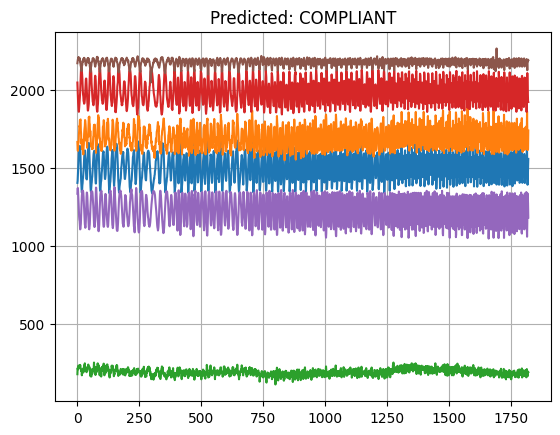

>>  Test2.csv

PREDICTION ON SIGNAL:  1.0  -->

COMPLIANT

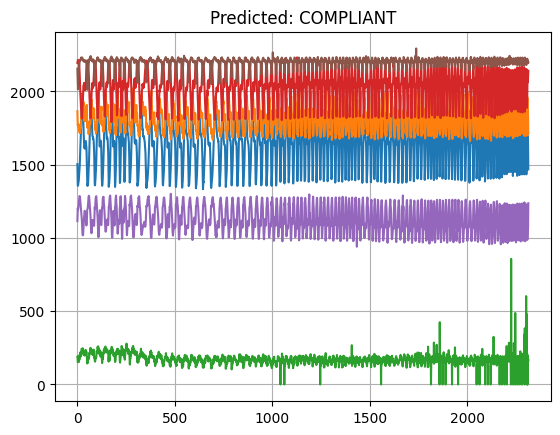

>>  Test3.csv

PREDICTION ON SIGNAL:  1.0  -->

COMPLIANT

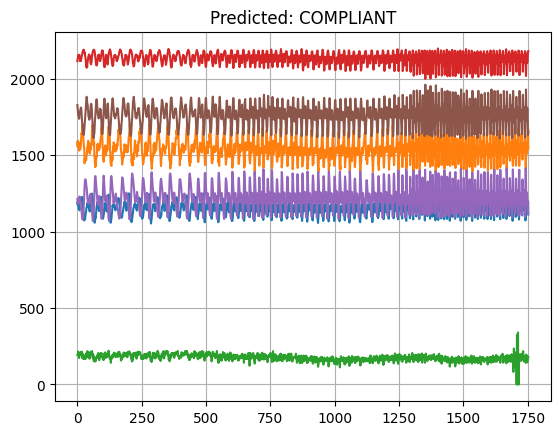

>>  Test4.csv

PREDICTION ON SIGNAL:  1.0  -->

COMPLIANT

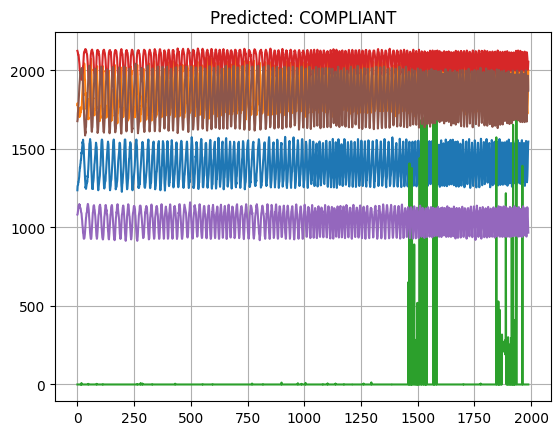

>>  Test5.csv

PREDICTION ON SIGNAL:  1.0  -->

COMPLIANT

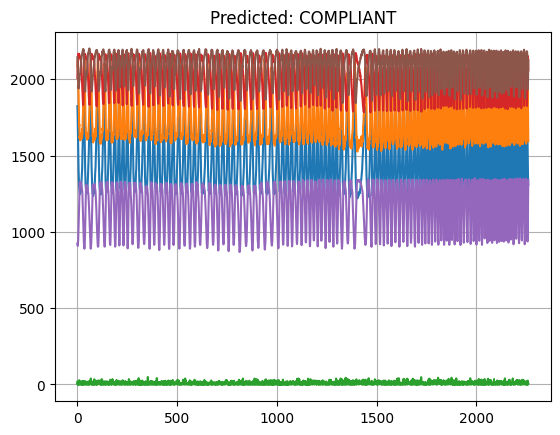

In [132]:
xtestt = []
paths=[]
for file in os.listdir("C:\\Users\\alber\\Desktop\\Files\\Università\\V ANNO ACCADEMICO\\Capstone Project\\Qura-ECC-Pump-Tester\\data2\\test"):
    data = np.genfromtxt(os.path.join("C:\\Users\\alber\\Desktop\\Files\\Università\\V ANNO ACCADEMICO\\Capstone Project\\Qura-ECC-Pump-Tester\\data2\\test",file), delimiter=',')
    xtestt.append(data)
    paths.append(file)
    

for i,x in enumerate(xtestt):
    print(">> ",paths[i])
    windows = [x[i:i+WINDOW_SIZE,WORKING_SENSORS] for i in range(0,x.shape[0]-WINDOW_SIZE,STRIDE)]
    windows = np.stack(windows)/3300

    outs = model.predict(windows)
    preds = np.zeros(outs.shape)
    preds[outs>=0.5]=1
    # print(preds.shape)
    # print("Confidence on windows:\n",outs.T)
    # print("Prediction on windows:\n",preds)
    plt.figure()
    plt.plot(x)
    print("PREDICTION ON SIGNAL: ",np.mean(preds)," --> ",end="")
    if np.mean(preds)>=0.5: 
        print("COMPLIANT")
        plt.title("Predicted: COMPLIANT")
    else: 
        print("NON COMPLIANT")
        plt.title("Predicted: NON COMPLIANT")
    plt.grid(True)
    plt.show()